[View in Colaboratory](https://colab.research.google.com/github/rafaelszp/dlnd_face_generation/blob/master/dlnd_face_generation.ipynb)

# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [ ]:
#!git clone https://github.com/rafaelszp/dlnd_face_generation.git
#!cp dlnd_face_generation/*.py .
#!pip install -U matplotlib==2.0.2
#!pip install tqdm

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.51KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

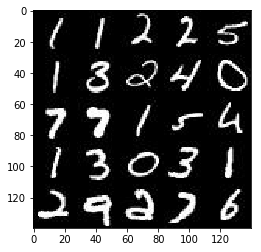

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

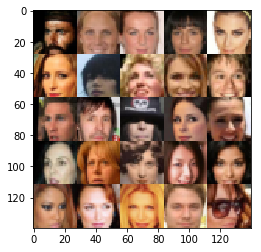

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    x = tf.placeholder(tf.float32, shape=(None, image_height, image_width, image_channels),name='input_real')
    z = tf.placeholder(tf.float32, shape=(None, z_dim),name='noise')
    l = tf.placeholder(tf.float32,name='learning_rate')

    return x, z, l



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/opt/co

In [6]:

leakyRelu = lambda x,alpha=0.2: tf.maximum(x*alpha,x)

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [33]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    kernel_init = tf.random_normal_initializer(stddev=0.02)
    
    def conv(images, n_filters, kernel_size=5, strides=2, kernel_initializer=kernel_init, padding='same',is_first=False):
      x = tf.layers.conv2d(images, n_filters, kernel_size, strides, kernel_initializer=kernel_initializer, padding=padding)
      x = leakyRelu(x)
      if(is_first):
        x = tf.layers.batch_normalization(x, training=True)
      return x
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input is 28x28x3
        x = conv(images,64,is_first=True)
        # 14x14x64        
        x = conv(x,128)
        # 7x7x128
        x = conv(x,256)
        # 4x4x256
        
        x = tf.reshape(x, (-1, 4*4*256))
        logits = tf.layers.dense(x, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [27]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    kernel_init = tf.random_normal_initializer(stddev=0.02)
    
    def deconv(inputs, n_filters, kernel_size=5, strides=2, kernel_initializer=kernel_init, padding='same',is_last=False):
      x = tf.layers.conv2d_transpose(inputs, n_filters, kernel_size, strides=strides, kernel_initializer=kernel_initializer, padding=padding)
      if(not is_last):
        x = leakyRelu(x)
        x = tf.layers.batch_normalization(x, training=is_train)

      return x
    
    with tf.variable_scope('generator', reuse=(not is_train)):
        x = tf.layers.dense(z, 7*7*256)
        x = tf.reshape(x, (-1, 7, 7, 256))
        x = leakyRelu(x)        
        x = tf.layers.batch_normalization(x, training=is_train)
        # 7x7x256
        x = deconv(x,128)
        # 14x14x128
        x = deconv(x,64)
        # 28x28x64
        
        logits = deconv(x,n_filters=out_channel_dim,kernel_size=3,strides=1,is_last=True)
        # 28x28x3
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [39]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
        
    gmodel = generator(input_z,out_channel_dim,is_train=True)
    dmodel, dmodel_logits = discriminator(input_real,reuse=False) 
    gxdmodel, gxdmodel_logits = discriminator(gmodel,reuse=True)
    
    dloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dmodel_logits,labels=tf.ones_like(dmodel)*0.9))
    gxdloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gxdmodel_logits,labels=tf.zeros_like(gxdmodel)))
    gloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gxdmodel_logits,labels=tf.ones_like(gxdmodel)))
    
    dloss = dloss + gxdloss
    
    
    return dloss, gloss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [40]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [g for g in t_vars if g.name.startswith('generator')]
    d_vars = [d for d in t_vars if d.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
      d_train_opt = tf.train.AdamOptimizer(learning_rate,beta1).minimize(d_loss,var_list=d_vars)
      g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1).minimize(g_loss,var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [41]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [ ]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    images, noisez, lr = model_inputs(data_shape[1],data_shape[2],data_shape[3],z_dim)
    dloss,gloss = model_loss(images,noisez,data_shape[3])
    d_train_opt,g_train_opt = model_opt(dloss,gloss,learning_rate,beta1)
    iterations = 0
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                #Doing the blablablablablalbla ff
                iterations +=1
                batch_noisez = np.random.uniform(-1,1,size=(batch_size,z_dim))
                dict_d = {
                  images: batch_images,
                  noisez: batch_noisez
                }
                dict_g = {
                    noisez: batch_noisez,
                    images: batch_images,
                }
                _ = sess.run(d_train_opt,feed_dict=dict_d)
                _ = sess.run(g_train_opt,feed_dict=dict_g)
                #calculating loss for the blablablablablalbla
                if(iterations % 10==0):
                  train_loss_d = dloss.eval({images:batch_images,noisez:batch_noisez})
                  train_loss_g = gloss.eval({noisez: batch_noisez})
                  print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                  
                if iterations % 100 == 0:
                    show_generator_output(sess, 25, noisez, data_shape[3], data_image_mode)
        print('Training done')
                
      

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Starting...
Epoch 1/2... Discriminator Loss: 0.5920... Generator Loss: 1.8070
Epoch 1/2... Discriminator Loss: 0.3813... Generator Loss: 3.1887
Epoch 1/2... Discriminator Loss: 0.3615... Generator Loss: 3.5590
Epoch 1/2... Discriminator Loss: 0.3949... Generator Loss: 2.9634
Epoch 1/2... Discriminator Loss: 0.3906... Generator Loss: 2.8895
Epoch 1/2... Discriminator Loss: 0.4353... Generator Loss: 2.3603
Epoch 1/2... Discriminator Loss: 0.7651... Generator Loss: 2.0683
Epoch 1/2... Discriminator Loss: 0.6119... Generator Loss: 1.5283
Epoch 1/2... Discriminator Loss: 0.9688... Generator Loss: 0.8237
Epoch 1/2... Discriminator Loss: 0.6658... Generator Loss: 1.4155


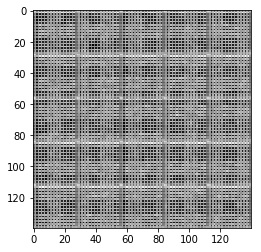

Epoch 1/2... Discriminator Loss: 1.0240... Generator Loss: 1.7596
Epoch 1/2... Discriminator Loss: 0.9051... Generator Loss: 1.0542
Epoch 1/2... Discriminator Loss: 1.2069... Generator Loss: 0.6114
Epoch 1/2... Discriminator Loss: 2.0448... Generator Loss: 0.2305
Epoch 1/2... Discriminator Loss: 1.1203... Generator Loss: 1.3596
Epoch 1/2... Discriminator Loss: 0.9982... Generator Loss: 1.2603
Epoch 1/2... Discriminator Loss: 1.1247... Generator Loss: 0.9986
Epoch 1/2... Discriminator Loss: 1.0243... Generator Loss: 1.1088
Epoch 1/2... Discriminator Loss: 1.3981... Generator Loss: 2.5501
Epoch 1/2... Discriminator Loss: 0.9632... Generator Loss: 1.5684


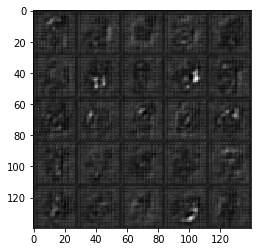

Epoch 1/2... Discriminator Loss: 1.3088... Generator Loss: 1.7547
Epoch 1/2... Discriminator Loss: 1.3079... Generator Loss: 2.3236
Epoch 1/2... Discriminator Loss: 1.1322... Generator Loss: 2.4480
Epoch 1/2... Discriminator Loss: 1.3166... Generator Loss: 0.6040
Epoch 1/2... Discriminator Loss: 0.9367... Generator Loss: 1.0914
Epoch 1/2... Discriminator Loss: 0.9166... Generator Loss: 1.1676
Epoch 1/2... Discriminator Loss: 0.6555... Generator Loss: 1.9679
Epoch 1/2... Discriminator Loss: 0.9786... Generator Loss: 0.9693
Epoch 1/2... Discriminator Loss: 0.6739... Generator Loss: 1.8147
Epoch 1/2... Discriminator Loss: 0.6936... Generator Loss: 1.4562


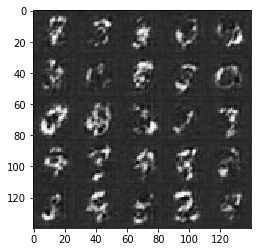

Epoch 1/2... Discriminator Loss: 0.8072... Generator Loss: 2.3504
Epoch 1/2... Discriminator Loss: 1.4842... Generator Loss: 0.4739
Epoch 1/2... Discriminator Loss: 0.7269... Generator Loss: 2.0450
Epoch 1/2... Discriminator Loss: 0.5660... Generator Loss: 2.5444
Epoch 1/2... Discriminator Loss: 1.6204... Generator Loss: 4.4446
Epoch 1/2... Discriminator Loss: 0.6785... Generator Loss: 1.8588
Epoch 1/2... Discriminator Loss: 0.7053... Generator Loss: 2.0583
Epoch 1/2... Discriminator Loss: 0.5101... Generator Loss: 2.3529
Epoch 1/2... Discriminator Loss: 0.7410... Generator Loss: 1.4402
Epoch 1/2... Discriminator Loss: 0.7644... Generator Loss: 1.4976


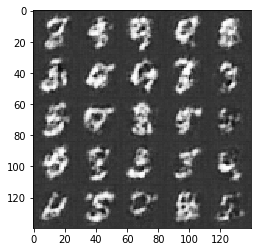

Epoch 1/2... Discriminator Loss: 0.8683... Generator Loss: 1.0562
Epoch 1/2... Discriminator Loss: 0.6197... Generator Loss: 1.6947
Epoch 1/2... Discriminator Loss: 0.6427... Generator Loss: 1.6675
Epoch 1/2... Discriminator Loss: 0.7883... Generator Loss: 1.3269
Epoch 1/2... Discriminator Loss: 0.8549... Generator Loss: 2.2342
Epoch 1/2... Discriminator Loss: 0.6194... Generator Loss: 2.1693
Epoch 1/2... Discriminator Loss: 0.7652... Generator Loss: 1.3489
Epoch 1/2... Discriminator Loss: 0.6164... Generator Loss: 2.1244
Epoch 1/2... Discriminator Loss: 0.6156... Generator Loss: 1.8041
Epoch 1/2... Discriminator Loss: 0.4525... Generator Loss: 2.9176


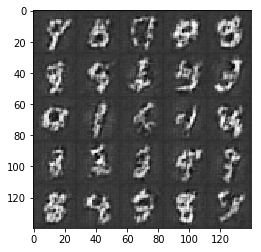

Epoch 1/2... Discriminator Loss: 0.8239... Generator Loss: 1.1342
Epoch 1/2... Discriminator Loss: 0.6615... Generator Loss: 2.4442
Epoch 1/2... Discriminator Loss: 0.8643... Generator Loss: 1.0338
Epoch 1/2... Discriminator Loss: 0.8143... Generator Loss: 2.9135
Epoch 1/2... Discriminator Loss: 1.2155... Generator Loss: 3.8093
Epoch 1/2... Discriminator Loss: 0.5736... Generator Loss: 2.1912
Epoch 1/2... Discriminator Loss: 0.5706... Generator Loss: 2.0233
Epoch 1/2... Discriminator Loss: 0.6425... Generator Loss: 1.6689
Epoch 1/2... Discriminator Loss: 0.8009... Generator Loss: 1.2239
Epoch 1/2... Discriminator Loss: 0.7165... Generator Loss: 3.8018


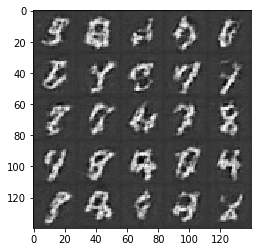

Epoch 1/2... Discriminator Loss: 1.8003... Generator Loss: 3.5053
Epoch 1/2... Discriminator Loss: 1.0250... Generator Loss: 1.0806
Epoch 2/2... Discriminator Loss: 0.8806... Generator Loss: 1.2026
Epoch 2/2... Discriminator Loss: 0.7336... Generator Loss: 1.6505
Epoch 2/2... Discriminator Loss: 0.7348... Generator Loss: 1.7525
Epoch 2/2... Discriminator Loss: 0.6764... Generator Loss: 1.6127
Epoch 2/2... Discriminator Loss: 0.7229... Generator Loss: 1.5787
Epoch 2/2... Discriminator Loss: 0.7319... Generator Loss: 1.4344
Epoch 2/2... Discriminator Loss: 0.6998... Generator Loss: 1.4644
Epoch 2/2... Discriminator Loss: 0.6070... Generator Loss: 2.2193


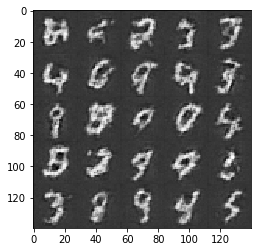

Epoch 2/2... Discriminator Loss: 0.7351... Generator Loss: 1.4065
Epoch 2/2... Discriminator Loss: 0.6585... Generator Loss: 1.7757
Epoch 2/2... Discriminator Loss: 0.9577... Generator Loss: 0.9360
Epoch 2/2... Discriminator Loss: 0.7716... Generator Loss: 1.2090
Epoch 2/2... Discriminator Loss: 0.6327... Generator Loss: 2.6691
Epoch 2/2... Discriminator Loss: 0.7627... Generator Loss: 3.0172
Epoch 2/2... Discriminator Loss: 0.6648... Generator Loss: 1.8406
Epoch 2/2... Discriminator Loss: 0.7310... Generator Loss: 3.1851
Epoch 2/2... Discriminator Loss: 0.6091... Generator Loss: 1.8729
Epoch 2/2... Discriminator Loss: 0.7594... Generator Loss: 1.3612


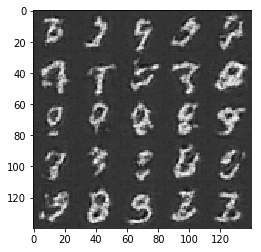

Epoch 2/2... Discriminator Loss: 0.6913... Generator Loss: 1.5169
Epoch 2/2... Discriminator Loss: 0.6247... Generator Loss: 3.0450
Epoch 2/2... Discriminator Loss: 0.7207... Generator Loss: 1.4524
Epoch 2/2... Discriminator Loss: 0.8051... Generator Loss: 1.2386
Epoch 2/2... Discriminator Loss: 0.9387... Generator Loss: 3.9612
Epoch 2/2... Discriminator Loss: 0.6743... Generator Loss: 2.4491
Epoch 2/2... Discriminator Loss: 0.7809... Generator Loss: 1.3223
Epoch 2/2... Discriminator Loss: 0.6633... Generator Loss: 2.5806
Epoch 2/2... Discriminator Loss: 0.5764... Generator Loss: 2.3767
Epoch 2/2... Discriminator Loss: 0.6847... Generator Loss: 2.4423


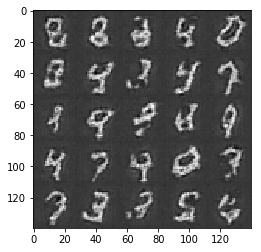

Epoch 2/2... Discriminator Loss: 0.5697... Generator Loss: 2.1401
Epoch 2/2... Discriminator Loss: 0.6478... Generator Loss: 2.1905
Epoch 2/2... Discriminator Loss: 3.0331... Generator Loss: 1.6350
Epoch 2/2... Discriminator Loss: 0.9187... Generator Loss: 1.1517
Epoch 2/2... Discriminator Loss: 0.8413... Generator Loss: 1.4284
Epoch 2/2... Discriminator Loss: 0.7493... Generator Loss: 1.6988
Epoch 2/2... Discriminator Loss: 0.6725... Generator Loss: 1.9005
Epoch 2/2... Discriminator Loss: 0.7199... Generator Loss: 1.9820
Epoch 2/2... Discriminator Loss: 0.6843... Generator Loss: 1.5823
Epoch 2/2... Discriminator Loss: 0.7375... Generator Loss: 1.3741


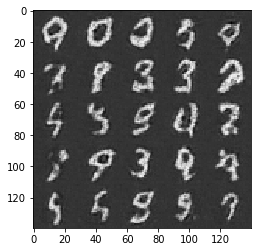

Epoch 2/2... Discriminator Loss: 0.5713... Generator Loss: 2.6232
Epoch 2/2... Discriminator Loss: 0.7233... Generator Loss: 1.4951
Epoch 2/2... Discriminator Loss: 0.6681... Generator Loss: 3.0136
Epoch 2/2... Discriminator Loss: 0.5240... Generator Loss: 2.3377
Epoch 2/2... Discriminator Loss: 0.6162... Generator Loss: 1.9992
Epoch 2/2... Discriminator Loss: 0.6941... Generator Loss: 1.5577
Epoch 2/2... Discriminator Loss: 0.6864... Generator Loss: 2.2939
Epoch 2/2... Discriminator Loss: 0.7061... Generator Loss: 2.3005
Epoch 2/2... Discriminator Loss: 0.6709... Generator Loss: 1.6480
Epoch 2/2... Discriminator Loss: 0.7306... Generator Loss: 1.4818


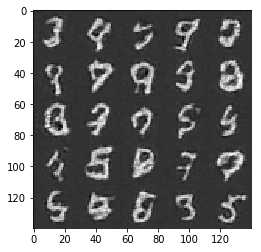

Epoch 2/2... Discriminator Loss: 0.8451... Generator Loss: 3.4114
Epoch 2/2... Discriminator Loss: 0.5722... Generator Loss: 2.4086
Epoch 2/2... Discriminator Loss: 0.7652... Generator Loss: 2.8657
Epoch 2/2... Discriminator Loss: 0.7669... Generator Loss: 2.4988
Epoch 2/2... Discriminator Loss: 0.6550... Generator Loss: 3.3339
Epoch 2/2... Discriminator Loss: 0.6864... Generator Loss: 1.8776
Epoch 2/2... Discriminator Loss: 0.6253... Generator Loss: 2.2801
Epoch 2/2... Discriminator Loss: 0.7241... Generator Loss: 3.0604
Epoch 2/2... Discriminator Loss: 0.6520... Generator Loss: 3.3466
Epoch 2/2... Discriminator Loss: 0.8727... Generator Loss: 1.1922


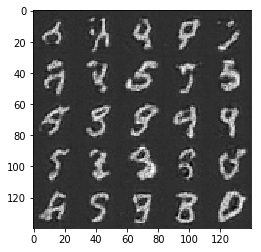

Epoch 2/2... Discriminator Loss: 0.8436... Generator Loss: 1.2247
Epoch 2/2... Discriminator Loss: 0.7608... Generator Loss: 1.5091
Epoch 2/2... Discriminator Loss: 0.5967... Generator Loss: 2.6810
Epoch 2/2... Discriminator Loss: 0.6654... Generator Loss: 3.2955
Epoch 2/2... Discriminator Loss: 0.7709... Generator Loss: 1.3694
Training done


In [46]:
batch_size = 96
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
print('Starting...')


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.6289... Generator Loss: 1.7264
Epoch 1/1... Discriminator Loss: 0.6297... Generator Loss: 1.8283
Epoch 1/1... Discriminator Loss: 0.5027... Generator Loss: 2.5309
Epoch 1/1... Discriminator Loss: 0.4820... Generator Loss: 2.5889
Epoch 1/1... Discriminator Loss: 0.4716... Generator Loss: 2.5800
Epoch 1/1... Discriminator Loss: 0.3900... Generator Loss: 3.2354
Epoch 1/1... Discriminator Loss: 0.5253... Generator Loss: 4.6270
Epoch 1/1... Discriminator Loss: 0.6004... Generator Loss: 1.8462
Epoch 1/1... Discriminator Loss: 0.8023... Generator Loss: 1.9367
Epoch 1/1... Discriminator Loss: 0.6390... Generator Loss: 2.5889


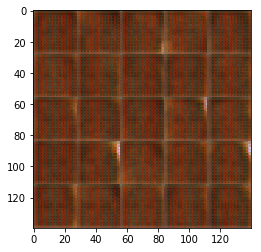

Epoch 1/1... Discriminator Loss: 0.6637... Generator Loss: 2.2349
Epoch 1/1... Discriminator Loss: 0.9920... Generator Loss: 1.1786
Epoch 1/1... Discriminator Loss: 0.8353... Generator Loss: 3.0162
Epoch 1/1... Discriminator Loss: 0.9495... Generator Loss: 1.3337
Epoch 1/1... Discriminator Loss: 0.9358... Generator Loss: 1.2962
Epoch 1/1... Discriminator Loss: 0.9242... Generator Loss: 2.0397
Epoch 1/1... Discriminator Loss: 1.1097... Generator Loss: 0.9644
Epoch 1/1... Discriminator Loss: 0.8644... Generator Loss: 1.7056
Epoch 1/1... Discriminator Loss: 0.9514... Generator Loss: 1.4419
Epoch 1/1... Discriminator Loss: 0.9003... Generator Loss: 1.6796


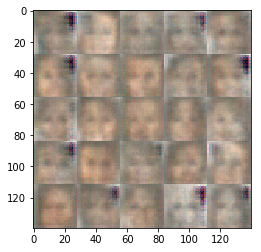

Epoch 1/1... Discriminator Loss: 0.9182... Generator Loss: 1.2055
Epoch 1/1... Discriminator Loss: 1.1794... Generator Loss: 0.9006
Epoch 1/1... Discriminator Loss: 1.0662... Generator Loss: 1.1007
Epoch 1/1... Discriminator Loss: 0.8315... Generator Loss: 2.2044
Epoch 1/1... Discriminator Loss: 0.9548... Generator Loss: 1.4763
Epoch 1/1... Discriminator Loss: 0.8759... Generator Loss: 1.7085
Epoch 1/1... Discriminator Loss: 1.1616... Generator Loss: 1.1464
Epoch 1/1... Discriminator Loss: 1.1485... Generator Loss: 1.6544
Epoch 1/1... Discriminator Loss: 1.1084... Generator Loss: 1.0985
Epoch 1/1... Discriminator Loss: 1.1070... Generator Loss: 1.3331


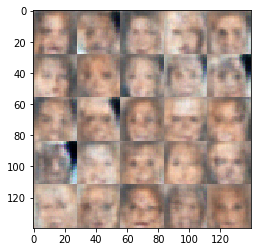

Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 2.0037
Epoch 1/1... Discriminator Loss: 1.1479... Generator Loss: 0.8836
Epoch 1/1... Discriminator Loss: 1.1333... Generator Loss: 1.1630
Epoch 1/1... Discriminator Loss: 1.0946... Generator Loss: 1.0127
Epoch 1/1... Discriminator Loss: 0.8907... Generator Loss: 1.5204
Epoch 1/1... Discriminator Loss: 0.9348... Generator Loss: 1.5756
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 1.2572
Epoch 1/1... Discriminator Loss: 4.0484... Generator Loss: 3.6300
Epoch 1/1... Discriminator Loss: 1.2756... Generator Loss: 0.7288
Epoch 1/1... Discriminator Loss: 1.1154... Generator Loss: 1.3026


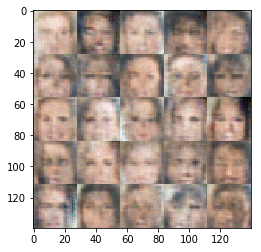

Epoch 1/1... Discriminator Loss: 0.8450... Generator Loss: 2.0659
Epoch 1/1... Discriminator Loss: 1.0819... Generator Loss: 0.9643
Epoch 1/1... Discriminator Loss: 1.1999... Generator Loss: 1.5185
Epoch 1/1... Discriminator Loss: 1.4862... Generator Loss: 0.9279
Epoch 1/1... Discriminator Loss: 0.9838... Generator Loss: 1.1475
Epoch 1/1... Discriminator Loss: 1.1398... Generator Loss: 1.5228
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 1.2929
Epoch 1/1... Discriminator Loss: 1.0130... Generator Loss: 1.1963
Epoch 1/1... Discriminator Loss: 1.0260... Generator Loss: 1.0496
Epoch 1/1... Discriminator Loss: 1.0671... Generator Loss: 1.0385


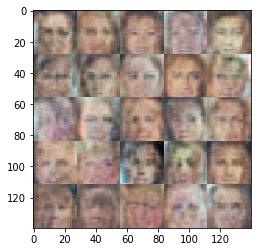

Epoch 1/1... Discriminator Loss: 1.0055... Generator Loss: 1.3057
Epoch 1/1... Discriminator Loss: 1.0917... Generator Loss: 1.1173
Epoch 1/1... Discriminator Loss: 1.0973... Generator Loss: 1.0812
Epoch 1/1... Discriminator Loss: 1.3744... Generator Loss: 1.4361
Epoch 1/1... Discriminator Loss: 0.7167... Generator Loss: 3.3591
Epoch 1/1... Discriminator Loss: 1.5849... Generator Loss: 0.8181
Epoch 1/1... Discriminator Loss: 0.8959... Generator Loss: 1.9513
Epoch 1/1... Discriminator Loss: 0.9074... Generator Loss: 1.6774
Epoch 1/1... Discriminator Loss: 0.9188... Generator Loss: 1.8471
Epoch 1/1... Discriminator Loss: 1.0289... Generator Loss: 1.3330


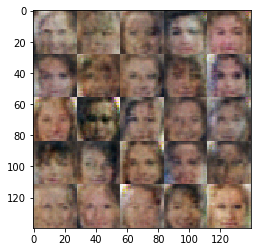

Epoch 1/1... Discriminator Loss: 0.9732... Generator Loss: 2.7293
Epoch 1/1... Discriminator Loss: 1.0083... Generator Loss: 2.6558
Epoch 1/1... Discriminator Loss: 1.0161... Generator Loss: 1.6647
Epoch 1/1... Discriminator Loss: 1.0709... Generator Loss: 1.9572
Epoch 1/1... Discriminator Loss: 1.1746... Generator Loss: 0.9385
Epoch 1/1... Discriminator Loss: 1.2390... Generator Loss: 1.3242
Epoch 1/1... Discriminator Loss: 0.9609... Generator Loss: 1.4250
Epoch 1/1... Discriminator Loss: 1.1675... Generator Loss: 0.8665
Epoch 1/1... Discriminator Loss: 1.0854... Generator Loss: 1.1381
Epoch 1/1... Discriminator Loss: 1.0494... Generator Loss: 1.1271


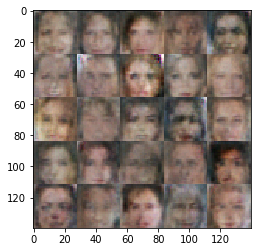

Epoch 1/1... Discriminator Loss: 1.2552... Generator Loss: 1.5371
Epoch 1/1... Discriminator Loss: 1.1154... Generator Loss: 0.9977
Epoch 1/1... Discriminator Loss: 1.0101... Generator Loss: 1.8252
Epoch 1/1... Discriminator Loss: 1.2921... Generator Loss: 0.7324
Epoch 1/1... Discriminator Loss: 0.9140... Generator Loss: 1.9684
Epoch 1/1... Discriminator Loss: 1.2350... Generator Loss: 1.2158
Epoch 1/1... Discriminator Loss: 1.2768... Generator Loss: 1.0663
Epoch 1/1... Discriminator Loss: 1.1478... Generator Loss: 1.2178
Epoch 1/1... Discriminator Loss: 0.8911... Generator Loss: 2.6369
Epoch 1/1... Discriminator Loss: 1.0375... Generator Loss: 1.1390


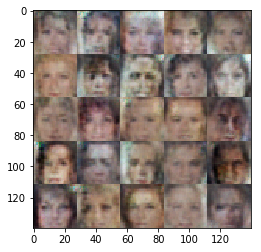

Epoch 1/1... Discriminator Loss: 1.0142... Generator Loss: 1.2334
Epoch 1/1... Discriminator Loss: 1.1467... Generator Loss: 1.4502
Epoch 1/1... Discriminator Loss: 1.3577... Generator Loss: 0.6190
Epoch 1/1... Discriminator Loss: 0.9134... Generator Loss: 1.7209
Epoch 1/1... Discriminator Loss: 1.1498... Generator Loss: 1.2253
Epoch 1/1... Discriminator Loss: 1.2377... Generator Loss: 0.8963
Epoch 1/1... Discriminator Loss: 1.4422... Generator Loss: 0.9825
Epoch 1/1... Discriminator Loss: 1.2201... Generator Loss: 0.8395
Epoch 1/1... Discriminator Loss: 1.1044... Generator Loss: 1.0403
Epoch 1/1... Discriminator Loss: 1.0964... Generator Loss: 0.9201


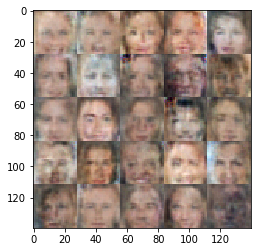

Epoch 1/1... Discriminator Loss: 1.1457... Generator Loss: 1.1690
Epoch 1/1... Discriminator Loss: 1.0396... Generator Loss: 1.4309
Epoch 1/1... Discriminator Loss: 1.1577... Generator Loss: 1.1144
Epoch 1/1... Discriminator Loss: 1.8636... Generator Loss: 1.6161
Epoch 1/1... Discriminator Loss: 1.0239... Generator Loss: 1.2610
Epoch 1/1... Discriminator Loss: 1.0062... Generator Loss: 1.9941
Epoch 1/1... Discriminator Loss: 1.2818... Generator Loss: 0.8572
Epoch 1/1... Discriminator Loss: 1.1988... Generator Loss: 0.7499
Epoch 1/1... Discriminator Loss: 1.1263... Generator Loss: 1.0646
Epoch 1/1... Discriminator Loss: 1.2424... Generator Loss: 0.9286


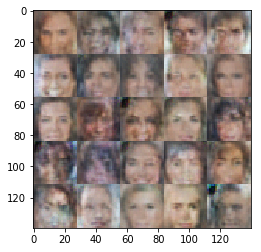

Epoch 1/1... Discriminator Loss: 1.2431... Generator Loss: 1.2175
Epoch 1/1... Discriminator Loss: 1.2467... Generator Loss: 0.8604
Epoch 1/1... Discriminator Loss: 1.2080... Generator Loss: 0.7515
Epoch 1/1... Discriminator Loss: 0.9061... Generator Loss: 2.2937
Epoch 1/1... Discriminator Loss: 1.3271... Generator Loss: 0.5742
Epoch 1/1... Discriminator Loss: 1.2321... Generator Loss: 0.8997
Epoch 1/1... Discriminator Loss: 1.0129... Generator Loss: 1.7539
Epoch 1/1... Discriminator Loss: 1.2186... Generator Loss: 0.9689
Epoch 1/1... Discriminator Loss: 1.0043... Generator Loss: 1.3080
Epoch 1/1... Discriminator Loss: 0.9211... Generator Loss: 1.6921


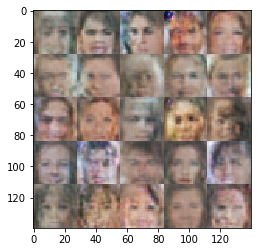

Epoch 1/1... Discriminator Loss: 0.9839... Generator Loss: 1.5623
Epoch 1/1... Discriminator Loss: 1.1748... Generator Loss: 0.9881
Epoch 1/1... Discriminator Loss: 0.9971... Generator Loss: 1.1792
Epoch 1/1... Discriminator Loss: 1.3389... Generator Loss: 0.8661
Epoch 1/1... Discriminator Loss: 1.2625... Generator Loss: 0.6737
Epoch 1/1... Discriminator Loss: 0.9373... Generator Loss: 1.5862
Epoch 1/1... Discriminator Loss: 1.2481... Generator Loss: 1.1925
Epoch 1/1... Discriminator Loss: 0.9383... Generator Loss: 1.3148
Epoch 1/1... Discriminator Loss: 1.1334... Generator Loss: 1.4514
Epoch 1/1... Discriminator Loss: 0.9932... Generator Loss: 1.2502


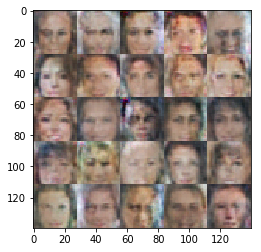

Epoch 1/1... Discriminator Loss: 0.8749... Generator Loss: 1.8327
Epoch 1/1... Discriminator Loss: 1.2186... Generator Loss: 1.0228
Epoch 1/1... Discriminator Loss: 1.0989... Generator Loss: 1.0253
Epoch 1/1... Discriminator Loss: 0.8265... Generator Loss: 2.1326
Epoch 1/1... Discriminator Loss: 0.8054... Generator Loss: 1.5289
Epoch 1/1... Discriminator Loss: 1.1912... Generator Loss: 1.4171
Epoch 1/1... Discriminator Loss: 1.0491... Generator Loss: 1.2234
Epoch 1/1... Discriminator Loss: 1.0024... Generator Loss: 1.2608
Epoch 1/1... Discriminator Loss: 1.2653... Generator Loss: 0.7781
Epoch 1/1... Discriminator Loss: 0.8189... Generator Loss: 2.0522


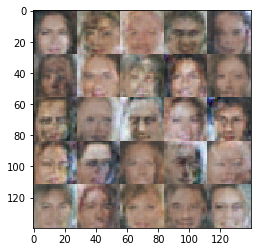

Epoch 1/1... Discriminator Loss: 1.0685... Generator Loss: 1.1820
Epoch 1/1... Discriminator Loss: 1.2249... Generator Loss: 0.7645
Epoch 1/1... Discriminator Loss: 1.2219... Generator Loss: 0.8915
Epoch 1/1... Discriminator Loss: 1.2092... Generator Loss: 0.8767
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.8700
Epoch 1/1... Discriminator Loss: 1.1423... Generator Loss: 1.0164
Epoch 1/1... Discriminator Loss: 0.9782... Generator Loss: 1.3872
Epoch 1/1... Discriminator Loss: 0.8545... Generator Loss: 1.8195
Epoch 1/1... Discriminator Loss: 0.9308... Generator Loss: 1.4201
Epoch 1/1... Discriminator Loss: 0.8748... Generator Loss: 1.9766


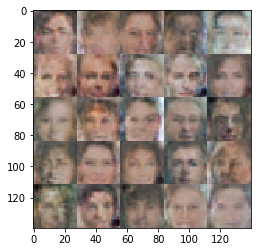

Epoch 1/1... Discriminator Loss: 0.9723... Generator Loss: 1.6001
Epoch 1/1... Discriminator Loss: 1.2586... Generator Loss: 0.7496
Epoch 1/1... Discriminator Loss: 1.2279... Generator Loss: 0.9255
Epoch 1/1... Discriminator Loss: 1.0939... Generator Loss: 1.0312
Epoch 1/1... Discriminator Loss: 1.2752... Generator Loss: 1.0310
Epoch 1/1... Discriminator Loss: 1.2042... Generator Loss: 0.9492
Epoch 1/1... Discriminator Loss: 0.8866... Generator Loss: 2.2020
Epoch 1/1... Discriminator Loss: 0.9249... Generator Loss: 1.9066
Epoch 1/1... Discriminator Loss: 1.1054... Generator Loss: 1.3057
Epoch 1/1... Discriminator Loss: 0.9056... Generator Loss: 1.8298


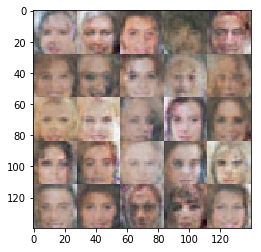

Epoch 1/1... Discriminator Loss: 0.9385... Generator Loss: 2.3414
Epoch 1/1... Discriminator Loss: 1.0168... Generator Loss: 1.5269
Epoch 1/1... Discriminator Loss: 1.2796... Generator Loss: 1.1854
Epoch 1/1... Discriminator Loss: 0.9776... Generator Loss: 1.3524
Epoch 1/1... Discriminator Loss: 0.8810... Generator Loss: 1.6690
Epoch 1/1... Discriminator Loss: 1.2303... Generator Loss: 1.0066
Epoch 1/1... Discriminator Loss: 0.8742... Generator Loss: 1.6153
Epoch 1/1... Discriminator Loss: 1.3642... Generator Loss: 2.0898
Epoch 1/1... Discriminator Loss: 1.2205... Generator Loss: 1.0222
Epoch 1/1... Discriminator Loss: 1.0555... Generator Loss: 1.3623


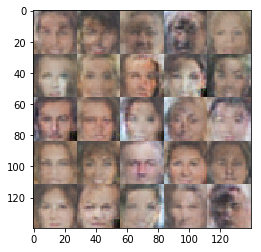

Epoch 1/1... Discriminator Loss: 1.2317... Generator Loss: 0.9597
Epoch 1/1... Discriminator Loss: 1.0774... Generator Loss: 1.5650
Epoch 1/1... Discriminator Loss: 1.1901... Generator Loss: 1.1515
Epoch 1/1... Discriminator Loss: 1.1818... Generator Loss: 1.3667
Epoch 1/1... Discriminator Loss: 1.3280... Generator Loss: 1.3031
Epoch 1/1... Discriminator Loss: 1.2872... Generator Loss: 0.8952
Epoch 1/1... Discriminator Loss: 1.2362... Generator Loss: 0.8942
Epoch 1/1... Discriminator Loss: 0.8915... Generator Loss: 1.9824
Epoch 1/1... Discriminator Loss: 1.2435... Generator Loss: 1.0595
Epoch 1/1... Discriminator Loss: 0.9266... Generator Loss: 1.5171


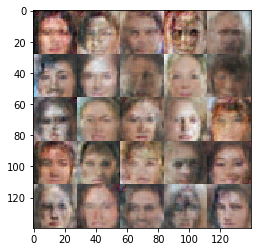

Epoch 1/1... Discriminator Loss: 1.2061... Generator Loss: 1.1059
Epoch 1/1... Discriminator Loss: 1.3597... Generator Loss: 0.6012
Epoch 1/1... Discriminator Loss: 1.3014... Generator Loss: 0.7165
Epoch 1/1... Discriminator Loss: 1.0065... Generator Loss: 1.4310
Epoch 1/1... Discriminator Loss: 0.8543... Generator Loss: 1.2420
Epoch 1/1... Discriminator Loss: 0.8462... Generator Loss: 1.4309
Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 1.3195
Epoch 1/1... Discriminator Loss: 1.0944... Generator Loss: 1.2182
Epoch 1/1... Discriminator Loss: 1.0389... Generator Loss: 1.1898
Epoch 1/1... Discriminator Loss: 1.0814... Generator Loss: 1.1008


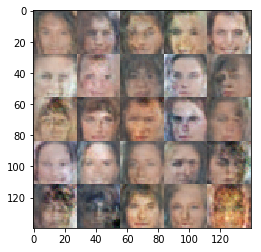

Epoch 1/1... Discriminator Loss: 1.1802... Generator Loss: 0.9850
Epoch 1/1... Discriminator Loss: 1.2642... Generator Loss: 0.8402
Epoch 1/1... Discriminator Loss: 1.1157... Generator Loss: 1.0897
Epoch 1/1... Discriminator Loss: 1.1031... Generator Loss: 0.9885
Epoch 1/1... Discriminator Loss: 1.1880... Generator Loss: 1.0292
Epoch 1/1... Discriminator Loss: 1.2932... Generator Loss: 0.9219
Epoch 1/1... Discriminator Loss: 1.2028... Generator Loss: 0.7925
Epoch 1/1... Discriminator Loss: 1.1314... Generator Loss: 1.3587
Epoch 1/1... Discriminator Loss: 1.1935... Generator Loss: 1.0125
Epoch 1/1... Discriminator Loss: 0.8407... Generator Loss: 1.5029


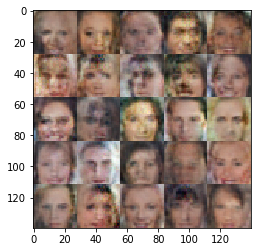

Epoch 1/1... Discriminator Loss: 0.7963... Generator Loss: 2.7827
Epoch 1/1... Discriminator Loss: 1.1625... Generator Loss: 1.0277
Epoch 1/1... Discriminator Loss: 1.2137... Generator Loss: 0.9026
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.8673
Epoch 1/1... Discriminator Loss: 1.2144... Generator Loss: 0.8284
Epoch 1/1... Discriminator Loss: 1.1740... Generator Loss: 1.1274
Epoch 1/1... Discriminator Loss: 1.1491... Generator Loss: 1.0131
Epoch 1/1... Discriminator Loss: 1.0991... Generator Loss: 1.0271
Epoch 1/1... Discriminator Loss: 0.9815... Generator Loss: 1.2490


In [ ]:
batch_size = 100
z_dim = 100
learning_rate = 2e-4
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.